## Import Data

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

In [3]:
pd.set_option('display.max_columns',500)

In [4]:
col_names = ["Ediblity","Cap-shape","Cap-surface","Cap-color","Bruises?",
             "Odor","Gill-attachment","Gill-spacing","Gill-size","Gill-color",
             "Stalk-shape","Stalk-root","Stalk-surface-above-ring","Stalk-surface-below-ring",
             "Stalk-color-above-ring","Stalk-color-below-ring","Veil-type","Veil-color",
             "Ring-number","Ring-type","Spore-print-color","Population","Habitat"]

df = pd.read_csv("agaricus-lepiota.data", header=None, names=col_names, na_values="?")
df.head()


,Ediblity,Cap-shape,Cap-surface,Cap-color,Bruises?,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-shape,Stalk-root,Stalk-surface-above-ring,Stalk-surface-below-ring,Stalk-color-above-ring,Stalk-color-below-ring,Veil-type,Veil-color,Ring-number,Ring-type,Spore-print-color,Population,Habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [5]:
# check to make sure the '?' converted to null values'
df.isnull().sum()

Ediblity                       0
Cap-shape                      0
Cap-surface                    0
Cap-color                      0
Bruises?                       0
Odor                           0
Gill-attachment                0
Gill-spacing                   0
Gill-size                      0
Gill-color                     0
Stalk-shape                    0
Stalk-root                  2480
Stalk-surface-above-ring       0
Stalk-surface-below-ring       0
Stalk-color-above-ring         0
Stalk-color-below-ring         0
Veil-type                      0
Veil-color                     0
Ring-number                    0
Ring-type                      0
Spore-print-color              0
Population                     0
Habitat                        0
dtype: int64

### Convert Data to be more readable

In [6]:
df['Ediblity'] = df['Ediblity'].replace({'p':0,'e':1})
df['Cap-shape'] = df['Cap-shape'].replace({'b':'bell','c':'conical','x':'convex','f':'flat','k':'knobbed','s':'sunken'})
df['Cap-surface'] = df['Cap-surface'].replace({'f':'fibrous','g':'grooves','y':'scaly','s':'smooth'})
df['Cap-color'] = df['Cap-color'].replace({'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow'})
df['Bruises?'] = df['Bruises?'].replace({'t':1,'f':0})
df['Odor'] = df['Odor'].replace({'a':'almond','l':'anise','c':'creosote','y':'fishy','f':'foul','m':'musty','n':'none','p':'pungent','s':'spicy'})
df['Gill-attachment'] = df['Gill-attachment'].replace({'a':'attached','d':'descending','f':'free','n':'notched'})
df['Gill-spacing'] = df['Gill-spacing'].replace({'c':'close','w':'crowded','d':'distant'})
df['Gill-size'] = df['Gill-size'].replace({'b':'broad','n':'narrow'})
df['Gill-color'] = df['Gill-color'].replace({'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow','k':'black','o':'orange'})
df['Stalk-shape'] = df['Stalk-shape'].replace({'e':'enlarging','t':'tapering'})
df['Stalk-root'] = df['Stalk-root'].replace({'b':'bulbous','c':'club','u':'cup','e':'equal','z':'rhizomorphs','r':'rooted'})
df['Stalk-surface-above-ring'] = df['Stalk-surface-above-ring'].replace({'f':'fibrous','y':'scaly','k':'silky','s':'smooth'})
df['Stalk-surface-below-ring'] = df['Stalk-surface-below-ring'].replace({'f':'fibrous','y':'scaly','k':'silky','s':'smooth'})
df['Stalk-color-above-ring'] = df['Stalk-color-above-ring'].replace({'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow'})
df['Stalk-color-below-ring'] = df['Stalk-color-below-ring'].replace({'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow'})
df['Veil-color'] = df['Veil-color'].replace({'n':'brown','o':'orange','w':'white','y':'yellow'})
df['Ring-number'] = df['Ring-number'].replace({'n':0,'o':1,'t':2})
df['Ring-type'] = df['Ring-type'].replace({'c':'cobwebby','e':'evanescent','f':'flaring','l':'large','n':'none','p':'pendant','s':'sheathing','z':'zone'})
df['Spore-print-color'] = df['Spore-print-color'].replace({'k':'black','n':'brown','b':'buff','h':'chocolate','r':'green','o':'orange','u':'purple','w':'white','y':'yellow'})
df['Population'] = df['Population'].replace({'a':'abundant','c':'clustered','n':'numerous','s':'scattered','v':'several','y':'solitary'})
df['Habitat'] = df['Habitat'].replace({'g':'grasses','l':'leaves','m':'meadows','p':'paths','u':'urban','w':'waste','d':'woods'})

## Split the data into train, val, and test

In [7]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    # Three way split using a function I found at 
    #   https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
    #   by user piRSquared

    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

train, val, test = train_validate_test_split(df, seed=35177)

print(train.shape, val.shape, test.shape)

import pandas_profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(train,minimal=True)

# profile.to_notebook_iframe()
profile.to_file(output_file='mushroom_classification_data_profile.html')

(4874, 23) (1624, 23) (1626, 23)


In [8]:
train.head()

,Ediblity,Cap-shape,Cap-surface,Cap-color,Bruises?,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-shape,Stalk-root,Stalk-surface-above-ring,Stalk-surface-below-ring,Stalk-color-above-ring,Stalk-color-below-ring,Veil-type,Veil-color,Ring-number,Ring-type,Spore-print-color,Population,Habitat
4838,0,convex,fibrous,yellow,0,foul,free,close,broad,gray,enlarging,bulbous,silky,silky,buff,brown,p,white,1,large,chocolate,solitary,woods
4873,0,flat,scaly,gray,0,foul,free,close,broad,gray,enlarging,bulbous,silky,silky,pink,buff,p,white,1,large,chocolate,solitary,grasses
6644,0,convex,smooth,red,0,fishy,free,close,narrow,buff,tapering,NaN,smooth,silky,white,pink,p,white,1,evanescent,white,several,woods
6486,0,flat,smooth,red,0,spicy,free,close,narrow,buff,tapering,NaN,smooth,silky,pink,white,p,white,1,evanescent,white,several,leaves
277,1,convex,scaly,white,1,almond,free,close,broad,white,enlarging,club,smooth,smooth,white,white,p,white,1,pendant,brown,numerous,meadows


## Wrangle the data and create features

In [9]:
def wrangle(X):
    X = X.copy()
    
    # drop the veil type because it has a constant value
    X = X.drop(columns=['Veil-type'])
    
    # create new features
    # Uniform Stalk Color
    X.loc[(X['Stalk-color-above-ring']==X['Stalk-color-below-ring']), 'Uniform-stalk-color'] = '1'
    X.loc[(X['Stalk-color-above-ring']!=X['Stalk-color-below-ring']), 'Uniform-stalk-color'] = '0'
    # Uniform Salk Surface
    X.loc[(X['Stalk-surface-above-ring']==X['Stalk-surface-below-ring']), 'Uniform-stalk-surface'] = '1'
    X.loc[(X['Stalk-surface-above-ring']!=X['Stalk-surface-below-ring']), 'Uniform-stalk-surface'] = '0'
        
    # Pleasant Oder
    X['Pleasant-odor'] = [1 if (x == 'almond' or x == 'anise' or x == 'none') else 0 for x in X['Odor']]
    
    
    return X

In [10]:
wrangle(train).sample(5)

,Ediblity,Cap-shape,Cap-surface,Cap-color,Bruises?,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-shape,Stalk-root,Stalk-surface-above-ring,Stalk-surface-below-ring,Stalk-color-above-ring,Stalk-color-below-ring,Veil-color,Ring-number,Ring-type,Spore-print-color,Population,Habitat,Uniform-stalk-color,Uniform-stalk-surface,Pleasant-odor
5720,1,knobbed,smooth,red,1,none,free,close,broad,white,enlarging,NaN,smooth,smooth,white,white,white,2,evanescent,white,clustered,waste,1,1,1
368,1,bell,scaly,yellow,1,almond,free,close,broad,gray,enlarging,club,smooth,smooth,white,white,white,1,pendant,brown,numerous,grasses,1,1,1
1720,1,flat,smooth,brown,0,none,free,crowded,broad,brown,tapering,equal,fibrous,fibrous,white,white,white,1,evanescent,black,scattered,grasses,1,1,1
2407,1,convex,fibrous,red,1,none,free,close,broad,white,tapering,bulbous,smooth,smooth,white,white,white,1,pendant,brown,solitary,woods,1,1,1
4147,0,convex,fibrous,yellow,0,foul,free,close,broad,h,enlarging,bulbous,silky,silky,buff,brown,white,1,large,chocolate,several,woods,0,1,0


In [11]:
w_train = wrangle(train)
w_val = wrangle(val)
w_test = wrangle(test)

In [12]:
# set the target and features
target = 'Ediblity'
features = w_train.drop(columns=target).columns.tolist()

#create an X and y for each set
X_train = w_train[features]
y_train = w_train[target]
X_val = w_val[features]
y_val = w_val[target]
X_test = w_test[features]
y_test = w_test[target]

In [13]:
X_val=X_val.reset_index(drop=True)
y_val=y_val.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)
y_test=y_test.reset_index(drop=True);

In [14]:
X_train.head()

,Cap-shape,Cap-surface,Cap-color,Bruises?,Odor,Gill-attachment,Gill-spacing,Gill-size,Gill-color,Stalk-shape,Stalk-root,Stalk-surface-above-ring,Stalk-surface-below-ring,Stalk-color-above-ring,Stalk-color-below-ring,Veil-color,Ring-number,Ring-type,Spore-print-color,Population,Habitat,Uniform-stalk-color,Uniform-stalk-surface,Pleasant-odor
0,convex,fibrous,yellow,0,foul,free,close,broad,gray,enlarging,bulbous,silky,silky,buff,brown,white,1,large,chocolate,solitary,woods,0,1,0
1,flat,scaly,gray,0,foul,free,close,broad,gray,enlarging,bulbous,silky,silky,pink,buff,white,1,large,chocolate,solitary,grasses,0,1,0
2,convex,smooth,red,0,fishy,free,close,narrow,buff,tapering,NaN,smooth,silky,white,pink,white,1,evanescent,white,several,woods,0,0,0
3,flat,smooth,red,0,spicy,free,close,narrow,buff,tapering,NaN,smooth,silky,pink,white,white,1,evanescent,white,several,leaves,0,0,0
4,convex,scaly,white,1,almond,free,close,broad,white,enlarging,club,smooth,smooth,white,white,white,1,pendant,brown,numerous,meadows,1,1,1


## Find the baseline

In [15]:
# Use the dummy classifier to estimate the most frequent result all the time.
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_val)
accuracy_score(y_val,y_pred)

0.5227832512315271

The baseline score would be 52.28%

## Use Permutation Importances

In [16]:
# separate the pipeline out  so that we can use the
# Permutation importance
transformers = make_pipeline(
                ce.OrdinalEncoder(),
                SimpleImputer(strategy='mean')
                              )
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(max_depth=10,random_state=7)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [17]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=10,
    random_state=7
)

permuter.fit(X_val_transformed,y_val);

C:\Users\kelsi\Anaconda3\envs\unit2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\kelsi\Anaconda3\envs\unit2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [18]:
# set feature names to a variable
feature_names = X_val.columns.tolist()
# show the weights for each column
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0714 ± 0.0054,Pleasant-odor
0.0070 ± 0.0016,Spore-print-color
0 ± 0.0000,Stalk-root
0 ± 0.0000,Cap-surface
0 ± 0.0000,Cap-color
0 ± 0.0000,Bruises?
0 ± 0.0000,Odor
0 ± 0.0000,Gill-attachment
0 ± 0.0000,Gill-spacing
0 ± 0.0000,Gill-size


## Make a model using Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

lr_pipe = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    LinearRegression()
)


lr_pipe.fit(X_train, y_train)

y_pred = lr_pipe.predict(X_val)
print('Validation Score:', lr_pipe.score(X_val,y_val))

Validation Score: 0.9505139276639347


## Make another model with XGBoost

In [20]:
# Run XGBoost with basic Parameters

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xg_pipe = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(n_estimators=100, random_state=7, n_jobs=-1)
)
xg_pipe.fit(X_train,y_train)

y_pred = xg_pipe.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val,y_pred))
y_pred_proba = xg_pipe.predict_proba(X_val)[:,-1]
print('AUC ROC Score:', roc_auc_score(y_val, y_pred_proba))

Validation Accuracy: 1.0
AUC ROC Score: 1.0


### Confusion Matrix from the above model

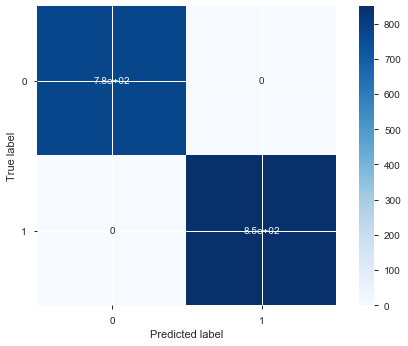

In [21]:
# plot the Confusion Matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xg_pipe, X_val, y_val,
                     cmap=plt.cm.Blues);

## Make some partial dependence plots to help explain the model

In [22]:
# set up matplotlib for the graphs (double it when using the image for the blog post)
plt.rcParams['figure.dpi'] = 72

In [39]:
X_train.dtypes

Cap-shape                   object
Cap-surface                 object
Cap-color                   object
Bruises?                     int64
Odor                        object
Gill-attachment             object
Gill-spacing                object
Gill-size                   object
Gill-color                  object
Stalk-shape                 object
Stalk-root                  object
Stalk-surface-above-ring    object
Stalk-surface-below-ring    object
Stalk-color-above-ring      object
Stalk-color-below-ring      object
Veil-color                  object
Ring-number                  int64
Ring-type                   object
Spore-print-color           object
Population                  object
Habitat                     object
Uniform-stalk-color         object
Uniform-stalk-surface       object
Pleasant-odor                int64
dtype: object

In [27]:
from pdpbox.pdp import pdp_isolate, pdp_plot

#set up a function so that I can call it for each feature I want to look at.
def graph_pdp(feature):
  
  #set the pipline for the pdp using XGBoost
  pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100, random_state=7, n_jobs=-1)
  )
  pipeline.fit(X_train,y_train)

  # set up isolated to use for the plot
  isolated = pdp_isolate(
      model = pipeline,
      dataset=X_val,
      model_features=X_val.columns,
      feature=feature,
      num_grid_points=10
  )

  # plot the pdp
  pdp_plot(isolated, feature_name=feature, plot_lines=True,
          frac_to_plot=.01);

In [28]:
graph_pdp('Odor')

TypeError: can't multiply sequence by non-int of type 'float'

## PDP with 2 Feature Interaction

In [37]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

# set a function for easy calling
def graph_2_pdp(features):
  
  #set the pipline for the pdp using XGBoost
  pipeline = make_pipeline(
      ce.OrdinalEncoder(),
      SimpleImputer(strategy='median'),
      XGBClassifier(n_estimators=100, random_state=7, n_jobs=-1)
  )
  pipeline.fit(X_train,y_train)

  # set up interaction to use for the plot
  interaction = pdp_interact(
      model=pipeline,
      dataset=X_val,
      model_features=X_val.columns,
      features=features
  )

  pdp_interact_plot(interaction, plot_type='grid',
                    feature_names=features);

In [36]:
graph_2_pdp(['Bruises?','Odor'])

TypeError: can't multiply sequence by non-int of type 'float'

## Using Plotly to make 3D models of the above graphs

In [33]:
import plotly.graph_objs as go

# set function for easy calling
def graph_2pdp_3d(features):
  
  #set the pipline for the pdp using XGBoost
  pipeline = make_pipeline(
      ce.OrdinalEncoder(),
      SimpleImputer(strategy='median'),
      XGBClassifier(n_estimators=100, random_state=7, n_jobs=-1)
  )
  pipeline.fit(X_train,y_train)

  # set up interaction to use for the plot
  interaction = pdp_interact(
      model=pipeline,
      dataset=X_val,
      model_features=X_val.columns,
      features=features
  )

  pdp = interaction.pdp.pivot_table(
      values='preds',
      columns=features[0],
      index=features[1]
  )[::-1] # Slice notation to reverse index order so y axis is ascending

  # set the surface
  surface = go.Surface(
      x=pdp.columns,
      y=pdp.index,
      z=pdp.values
  )

  #setup the layout for the graph
  layout = go.Layout(
      scene=dict(
          xaxis=dict(title=features[0]),
          yaxis=dict(title=features[1]),
          zaxis=dict(title=target)
      )
  )

  # graph the pdp interaction
  fig = go.Figure(surface,layout)
  fig.show()

In [34]:
graph_2pdp_3d(['Gill-attachment','Cap-shape'])

TypeError: can't multiply sequence by non-int of type 'float'

## Shapley Force Plots